# Insiders Clustering Project

# 0.0 General Area

## 0.1 Imports

In [18]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import warnings
import re

from matplotlib          import pyplot as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly              import express as px

import umap.umap_ as umap

## 0.2 Support Functions

In [2]:
# data cleaning functions
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    df = df.rename( columns = {'customer' : 'customer_id' } )
    df = df.drop( 'unnamed:8', axis=1 )

    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()
warnings.filterwarnings( 'ignore' )

## 0.3 Load Data

In [3]:
df_raw = pd.read_csv( '../data/Ecommerce.csv', low_memory=False, encoding='latin1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


## 0.4 Rename Columns

In [4]:
df_raw = rename_columns( df_raw )
df_raw.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Data Cleaning

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [6]:
print(f'Number of rows: { df1.shape[0] } ')
print(f'Number of cols: { df1.shape[1] } ')

Number of rows: 541909 
Number of cols: 8 


## 1.2 List Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check N/A

In [8]:
# number of rows with NA values by column
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Fillout N/A

In [9]:
#df1['description'].fillna( 'Undefined', inplace=True )
#df1['customer'].fillna( 10000, inplace=True )

## 1.5 Drop N/A Values

In [10]:
df1 = df1.dropna( subset = ['description', 'customer_id'] )

print(f'Removed data : { round( 1 - ( df1.shape[0] / df_raw.shape[0] ), 2) } ') 
print(f'Number of rows Updated: { df1.shape[0] } ')

Removed data : 0.25 
Number of rows Updated: 406829 


## 1.6 Change Data Types

In [11]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


# 2.0 Data Description

In [12]:
df2 = df1.copy()

## 2.1 Descriptive Statistics

In [13]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 2.2.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 2.2.2 Categorical Attributes

In [16]:
df_cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [24]:
# identify invoice_no with letters
index = df_cat_attributes['invoice_no'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) )
len( df_cat_attributes.loc[ index, 'invoice_no'] )

8905

In [23]:
# identify stock_code with letters
index = df_cat_attributes['stock_code'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) )
len( df_cat_attributes.loc[ index, 'stock_code'] )

35809

In [26]:
index = df_cat_attributes['stock_code'].apply( lambda x : bool( re.search( '^[a-zA-Z]+$', x ) ) )
len( df_cat_attributes.loc[ index, 'stock_code'] )

1774

# 3.0 Data Filtering

In [27]:
df3 = df2.copy()

In [ ]:
# ===== Numerical Attributes ========

# unit_price > 0.0
df3 = df3[ df3['unit_price'] > 0.010]

# stock_code != [ POST, D, M, DOT, CRUK, C2 ]
df3 = df3[ ~df3['stock_code'].isin( [ 'POST', 'D', 'M', 'DOT', 'CRUK', 'C2' ] ) ]

# separate original dataset in two: purchases and returs
df3_returns   = df3[ df3['quantity'] < 0]
df3_purchases = df3[ df3['quantity'] > 0]

# 4.0 Feature Engineering

In [13]:
df4 = df3.copy()

## 4.1 Feature Creation

In [14]:
# creating gross revenue
df4['gross_revenue'] = df4['quantity'] * df4['unit_price']

In [15]:
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom,20.34


In [16]:
# creating customers dataframe
df_customer = df4.drop( columns= ['invoice_no', 'stock_code', 'description', 'quantity', 
                                  'invoice_date', 'unit_price', 'country', 'gross_revenue'], axis=1).drop_duplicates( ignore_index=True )
df_customer.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [17]:
# creating customer monetary dataframe
df_monetary = ( df4[['customer_id', 'gross_revenue']].
                        groupby('customer_id').
                        sum().
                        reset_index() )
df_monetary.head()

,customer_id,gross_revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [18]:
# creating number of purchases dataframe by customer
df_frequency = ( df4[['customer_id', 'invoice_no']].
                        groupby('customer_id').
                        nunique().
                        reset_index().
                        rename( columns={ 'invoice_no' : 'purchase_frequency' } ) )
df_frequency.head()

,customer_id,purchase_frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [19]:
# creating number of purchases dataframe by customer
max_invoice_date = df4['invoice_date'].max()

df_recency = ( df4[['customer_id', 'invoice_date']].
                        groupby('customer_id').
                        max().
                        reset_index().
                        rename( columns={ 'invoice_date' : 'last_purchase' } ) )

df_recency['recency_days'] =  ( max_invoice_date - df_recency['last_purchase'] ).dt.days
df_recency = df_recency.drop( 'last_purchase', axis=1 )
df_recency.head()

,customer_id,recency_days
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [20]:
# creating average ticket by customer dataframe
df_avg_ticket = ( df4[['customer_id', 'gross_revenue']].
                        groupby('customer_id').
                        mean().
                        reset_index().
                        rename( columns={ 'gross_revenue' : 'average_ticket' } ) )

df_avg_ticket.head()

,customer_id,average_ticket
0,12346.0,0.000000
1,12347.0,23.681319
2,12348.0,57.975484
3,12349.0,24.076027
4,12350.0,19.670588


In [21]:
# merging dataframes by customer
df4 = pd.merge( df_customer, df_recency, how='left', on='customer_id' )
df4 = pd.merge( df4, df_frequency, how='left', on='customer_id' )
df4 = pd.merge( df4, df_monetary, how='left', on='customer_id' )
df4 = pd.merge( df4, df_avg_ticket, how='left', on='customer_id' )

df4.head()

,customer_id,recency_days,purchase_frequency,gross_revenue,average_ticket
0,17850.0,302,35,5288.63,16.950737
1,13047.0,31,18,3079.10,15.709694
2,12583.0,2,18,7187.34,28.634821
3,13748.0,95,5,948.25,33.866071
4,15100.0,330,6,635.10,105.850000


# 5.0 Exploratory Data Analysis

In [23]:
df5 = df4.copy()

# 6.0 Data Preparation

In [24]:
df6 = df5.copy()

# 7.0 Feature Selection

In [25]:
df7 = df6.copy()

# 8.0 Hyperparameter Fine-Tuning

In [26]:
df8 = df7.copy()

X = df8.drop( columns='customer_id' )
X.head()


,recency_days,purchase_frequency,gross_revenue,average_ticket
0,302,35,5288.63,16.950737
1,31,18,3079.10,15.709694
2,2,18,7187.34,28.634821
3,95,5,948.25,33.866071
4,330,6,635.10,105.850000


## 8.1 Within-Cluster Sum of Square (WSS)

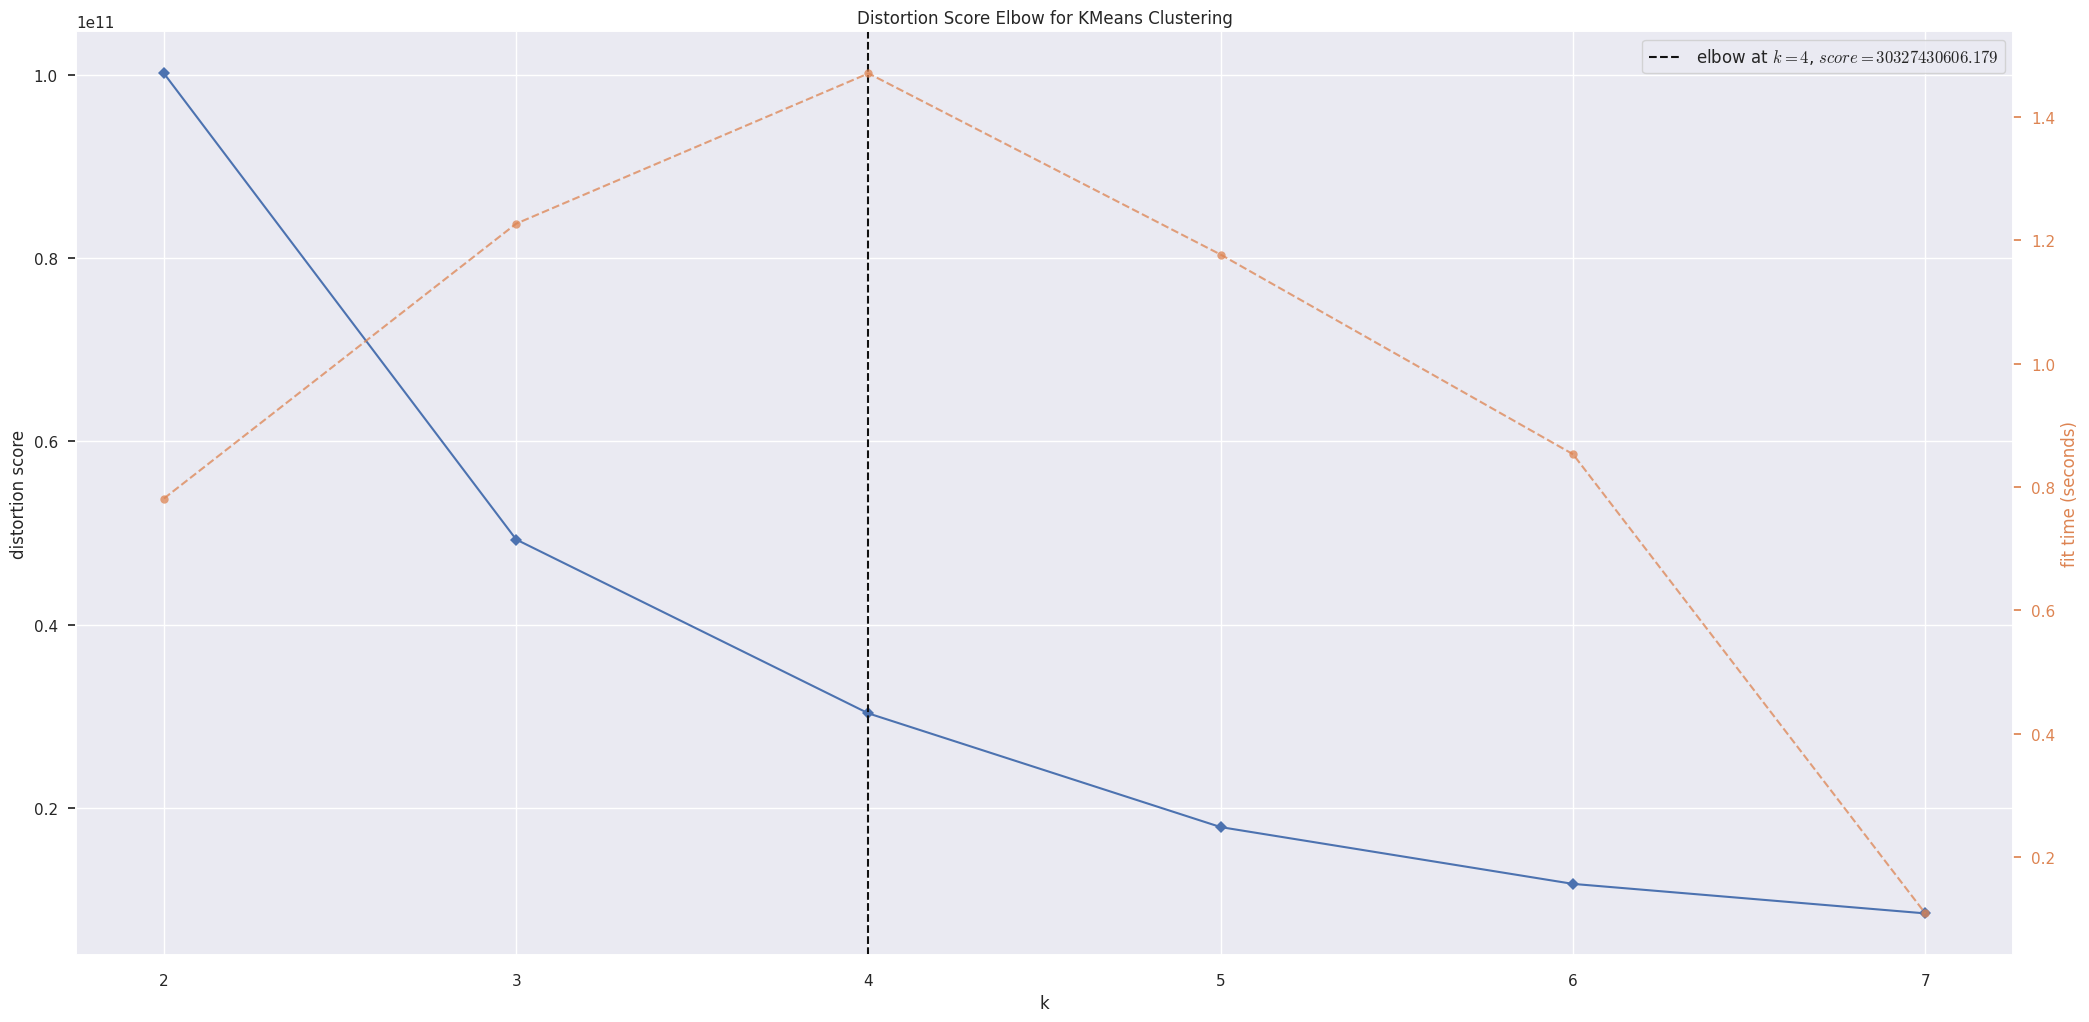

In [27]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timing=False )
kmeans.fit( X )
kmeans.show();

## 8.2 Silhouette Score

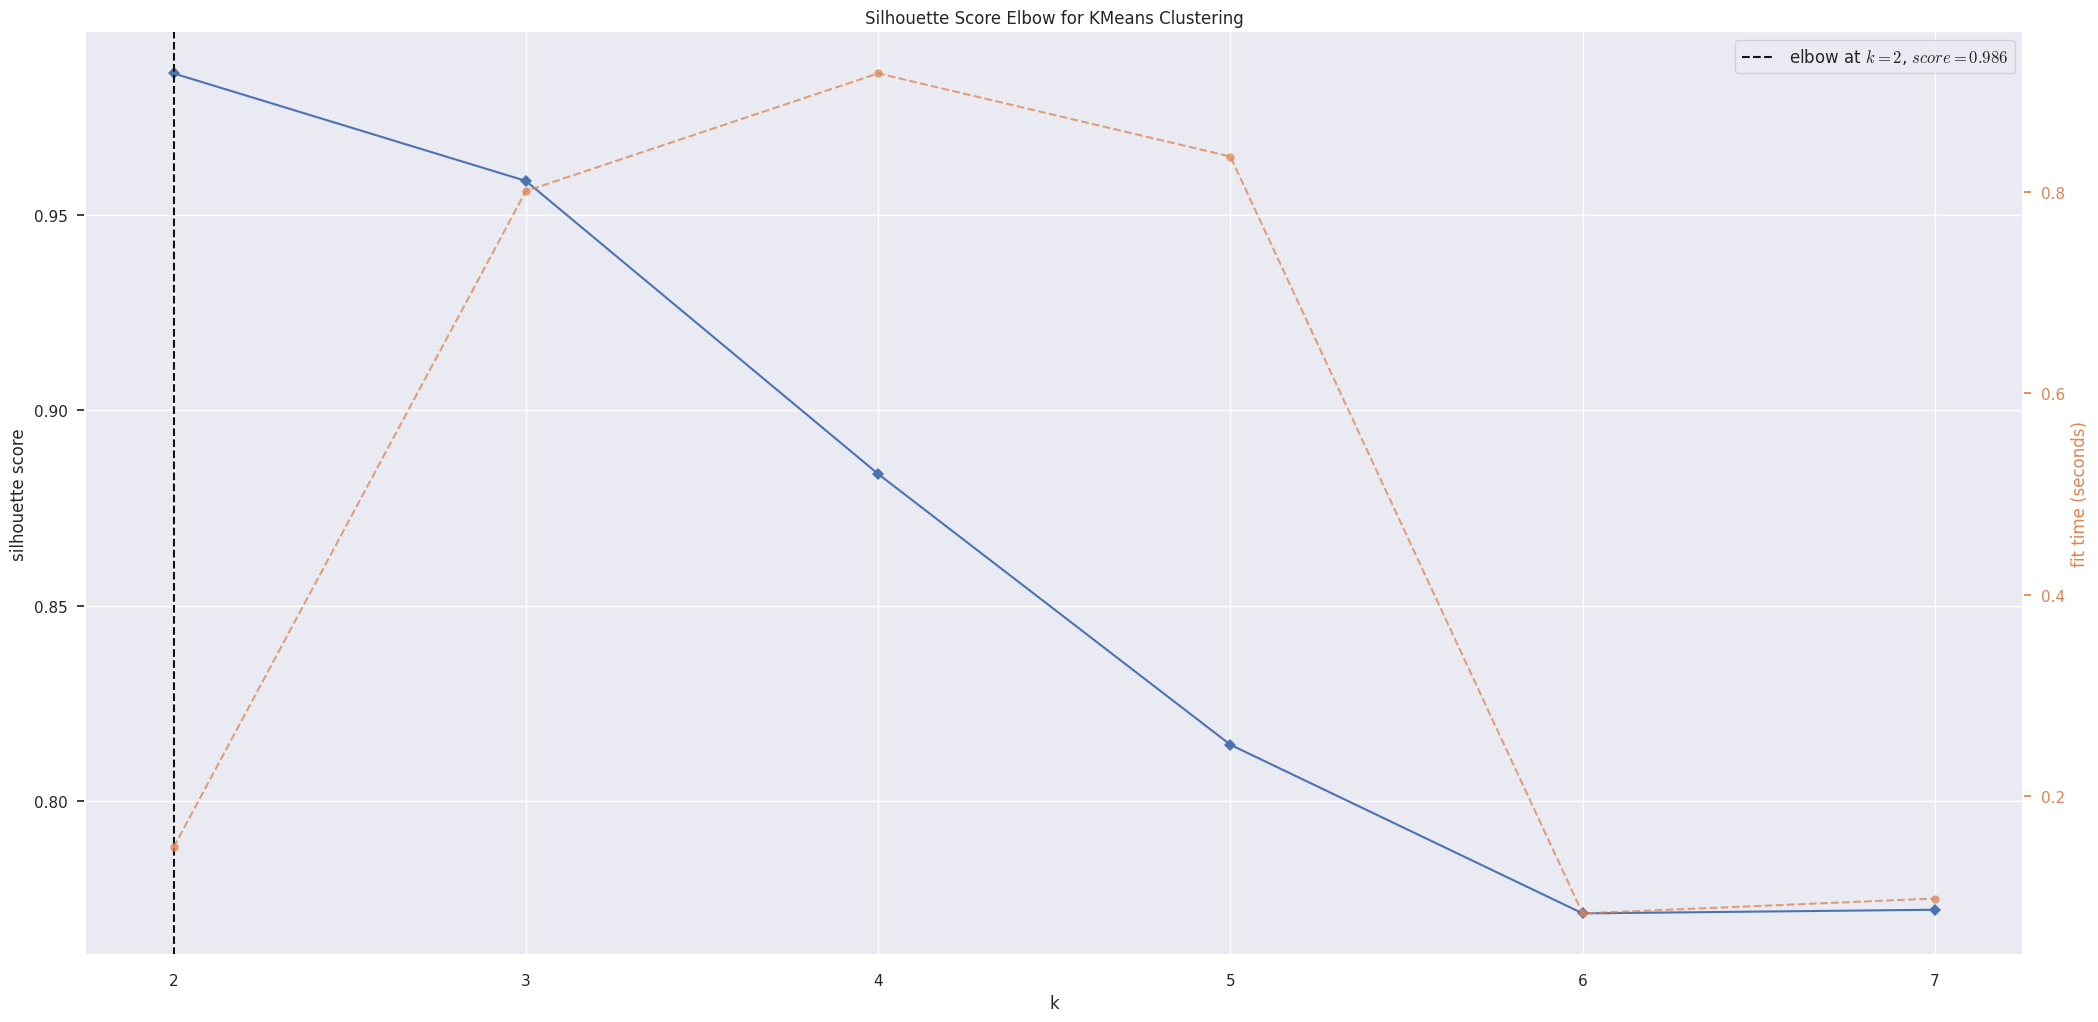

In [28]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timing=False )
kmeans.fit( X )
kmeans.show();

## 8.3 Silhouette Analysis

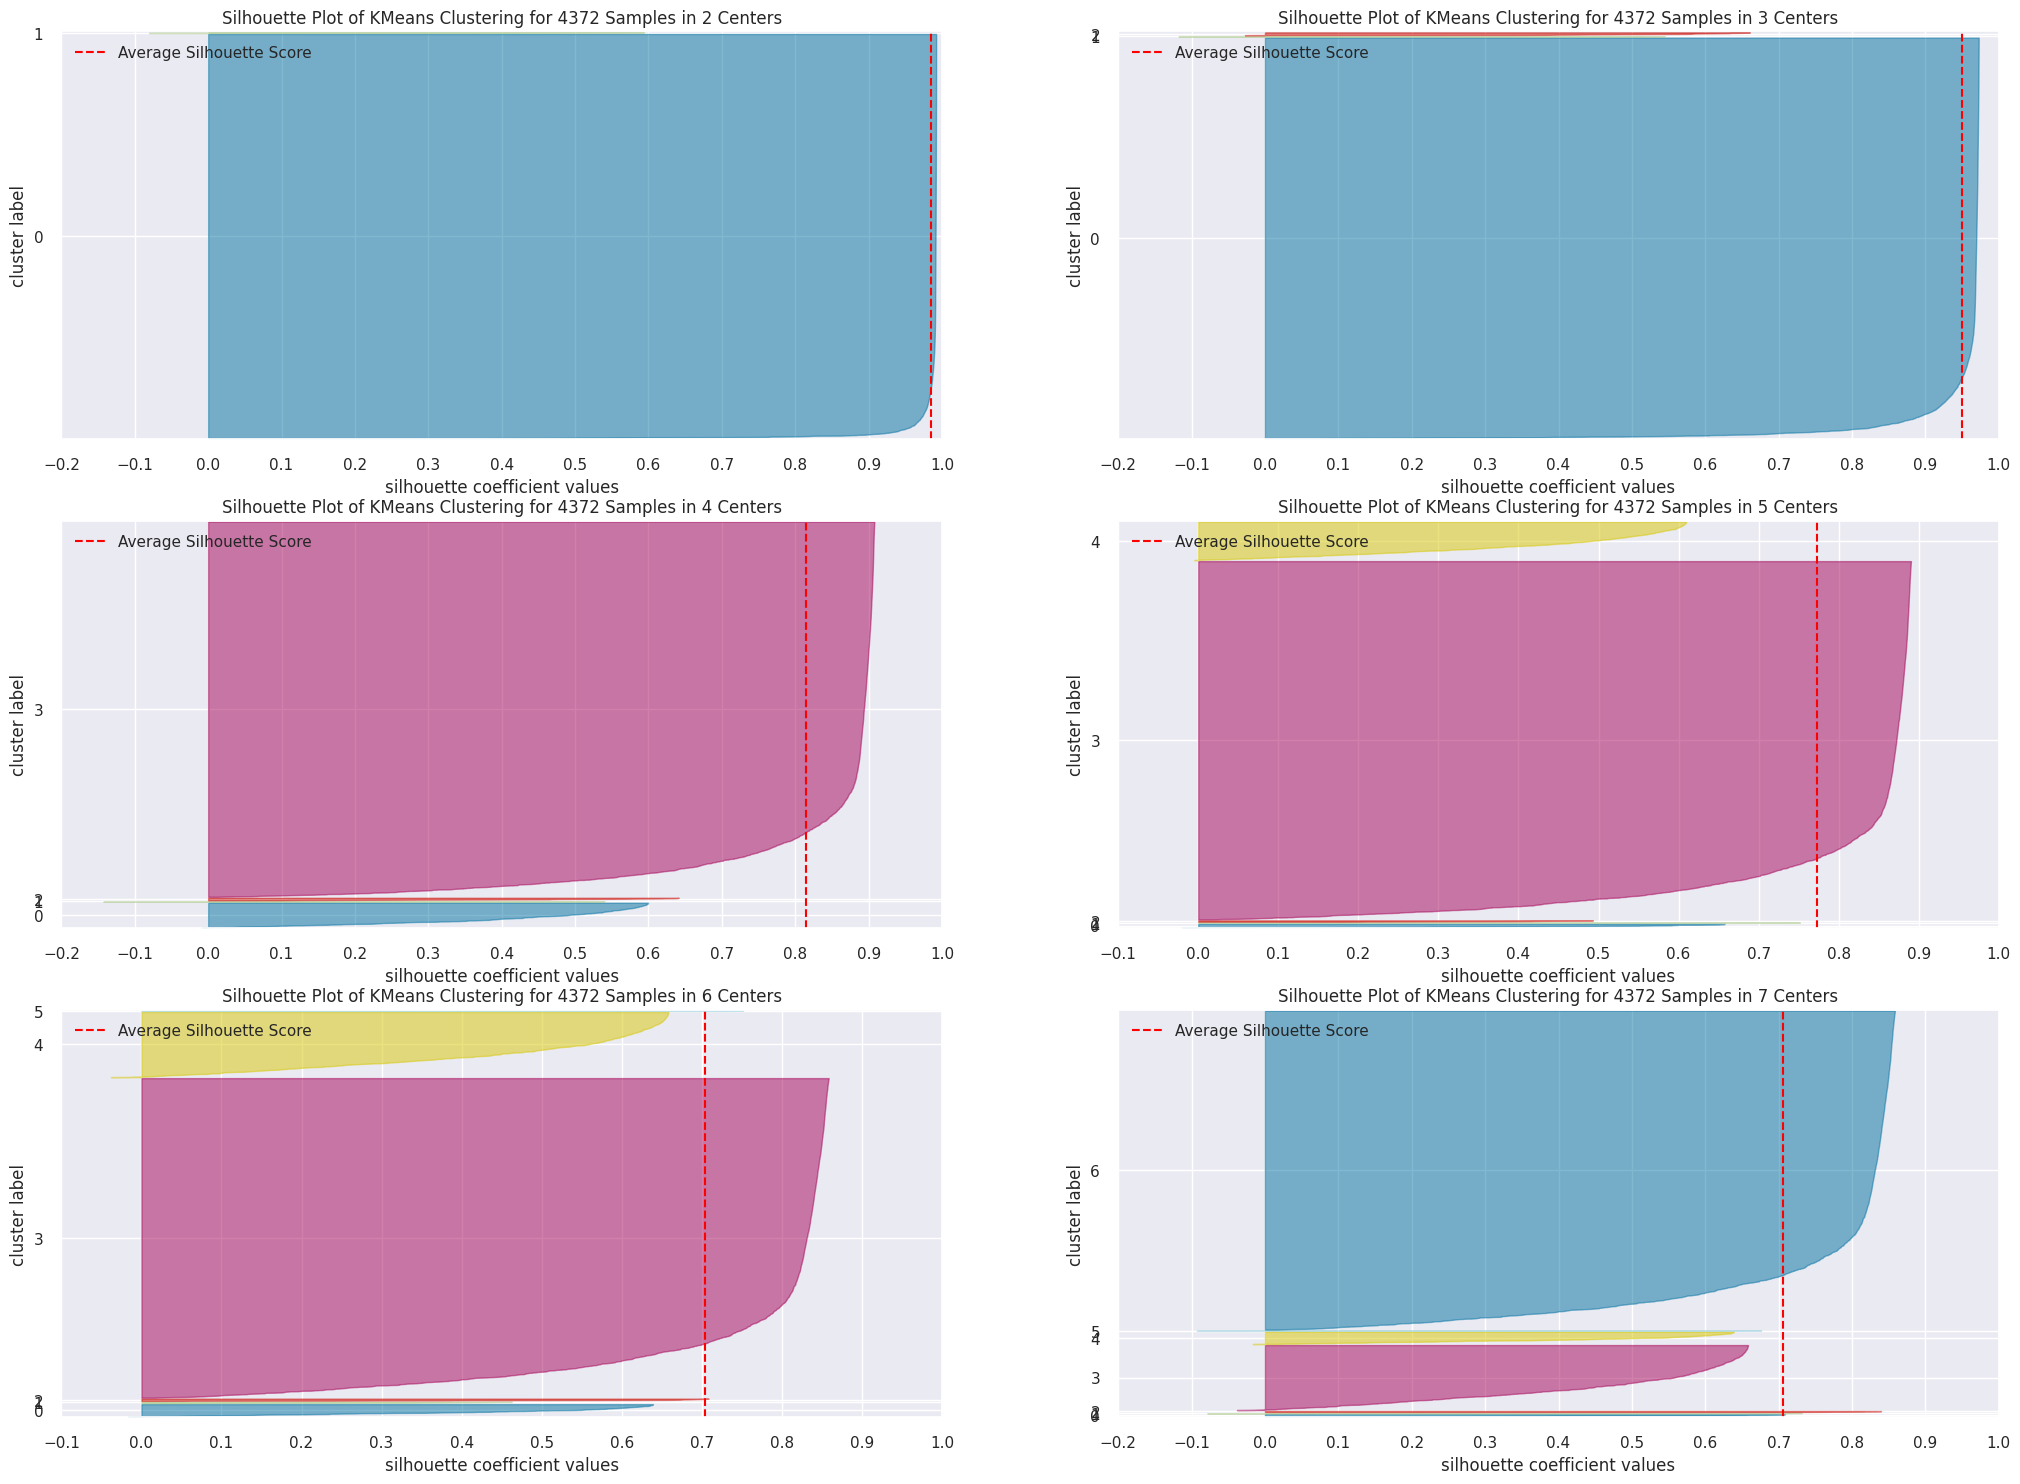

In [29]:
clusters = [2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(3, 2, figsize=(25, 18) )

for k in clusters:
    q, mod = divmod(k, 2)
    
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42 )
    visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick', ax=axes[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# 9.0 Model Training

In [30]:
df9 = df8.copy()

## 9.1 K-Means

In [31]:
# model definition
k=3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model traning
kmeans.fit( X )

# clustering
labels = kmeans.labels_


## 9.2 Cluster Validation

In [32]:
# WSS - Within Cluster Sum of Square
print(f'WSS : { kmeans.inertia_ } ' )

## SS - Silhouette Score
print(f'SS : { m.silhouette_score( X, labels, metric="euclidean" ) } ' )

WSS : 52900059994.70387 
SS : 0.9492955993916989 


# 10.0 Cluster Analysis

In [33]:
df10 = df9.copy()

df10['cluster'] = labels
df10.head()

,customer_id,recency_days,purchase_frequency,gross_revenue,average_ticket,cluster
0,17850.0,302,35,5288.63,16.950737,0
1,13047.0,31,18,3079.10,15.709694,0
2,12583.0,2,18,7187.34,28.634821,0
3,13748.0,95,5,948.25,33.866071,0
4,15100.0,330,6,635.10,105.850000,0


## 10.1 Visualization Inspection

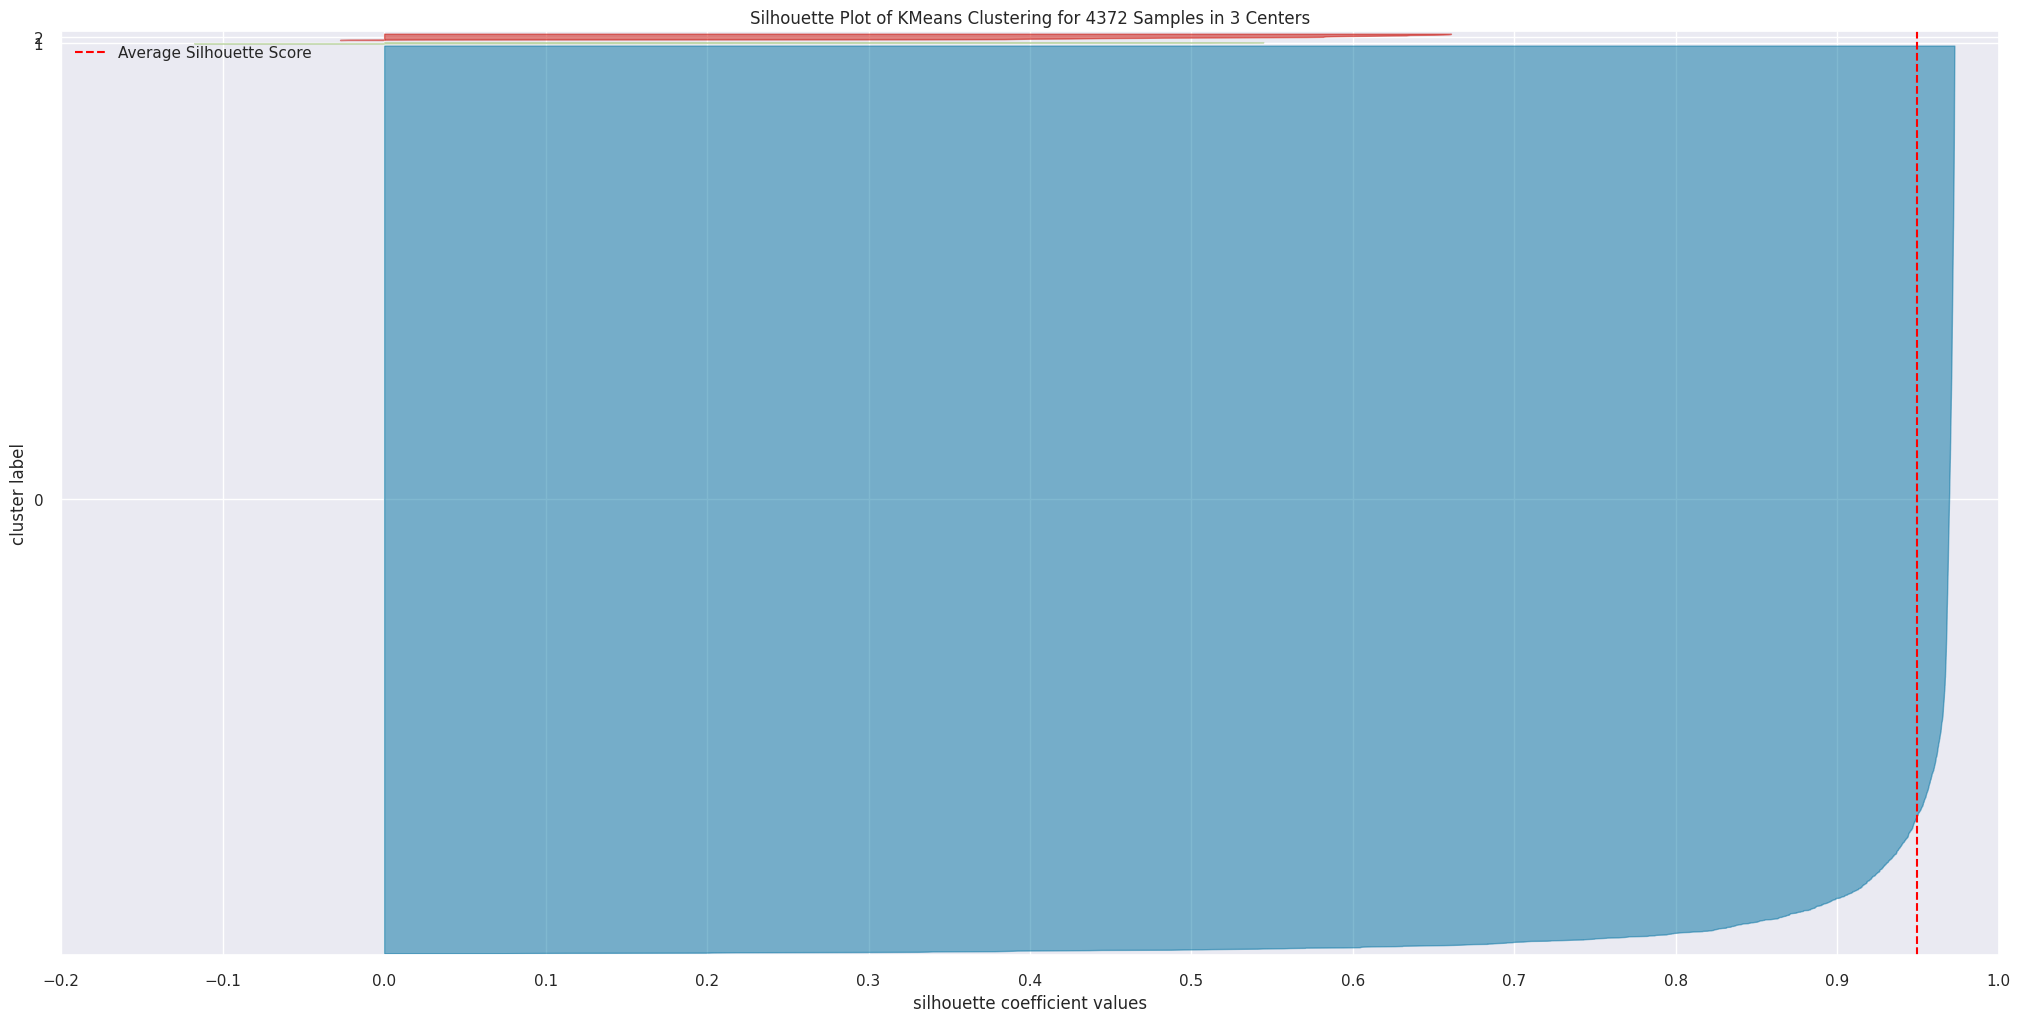

In [34]:
#fig = px.scatter_3d( df10, x='recency_days', y='purchase_frequency', z='gross_revenue', color='cluster' )
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors = 'yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 10.2 2D Plot

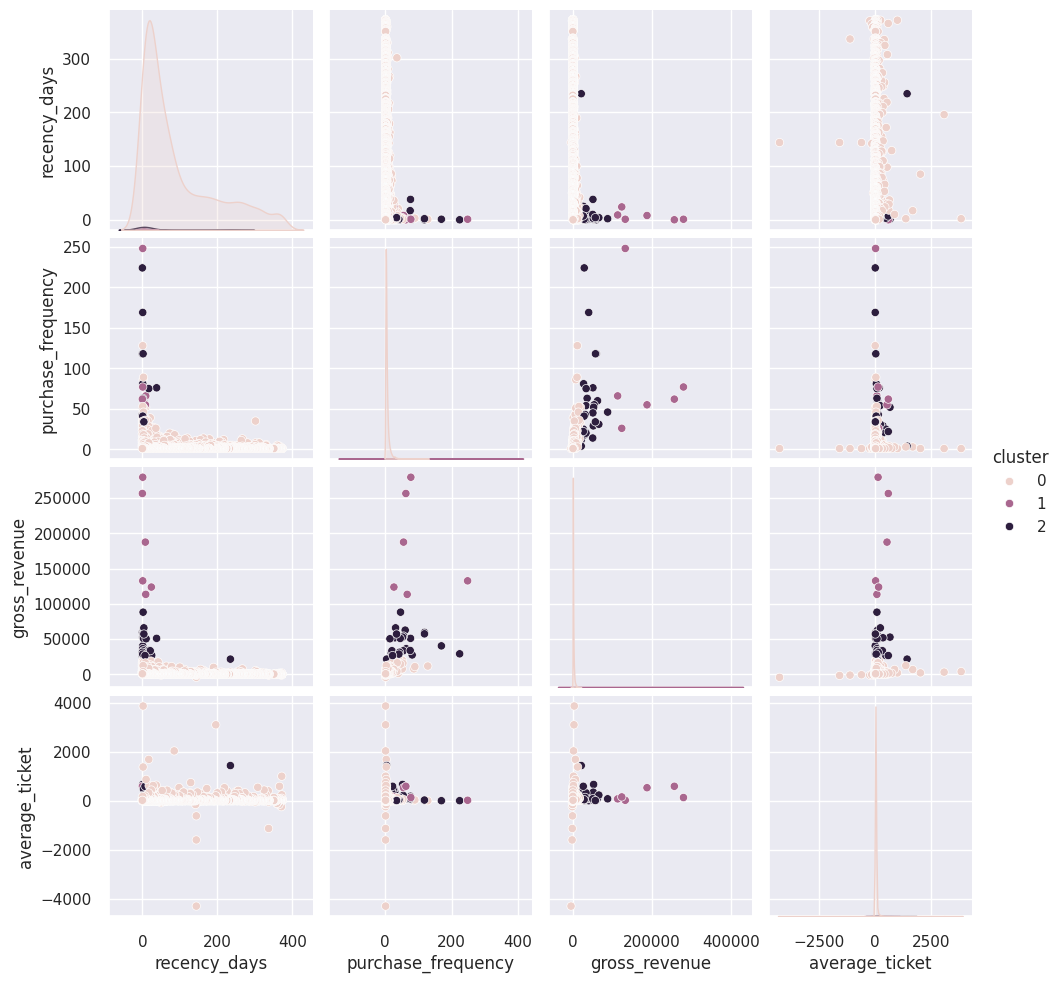

In [35]:
df_viz = df10.drop( 'customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster');

## 10.3 UMAP

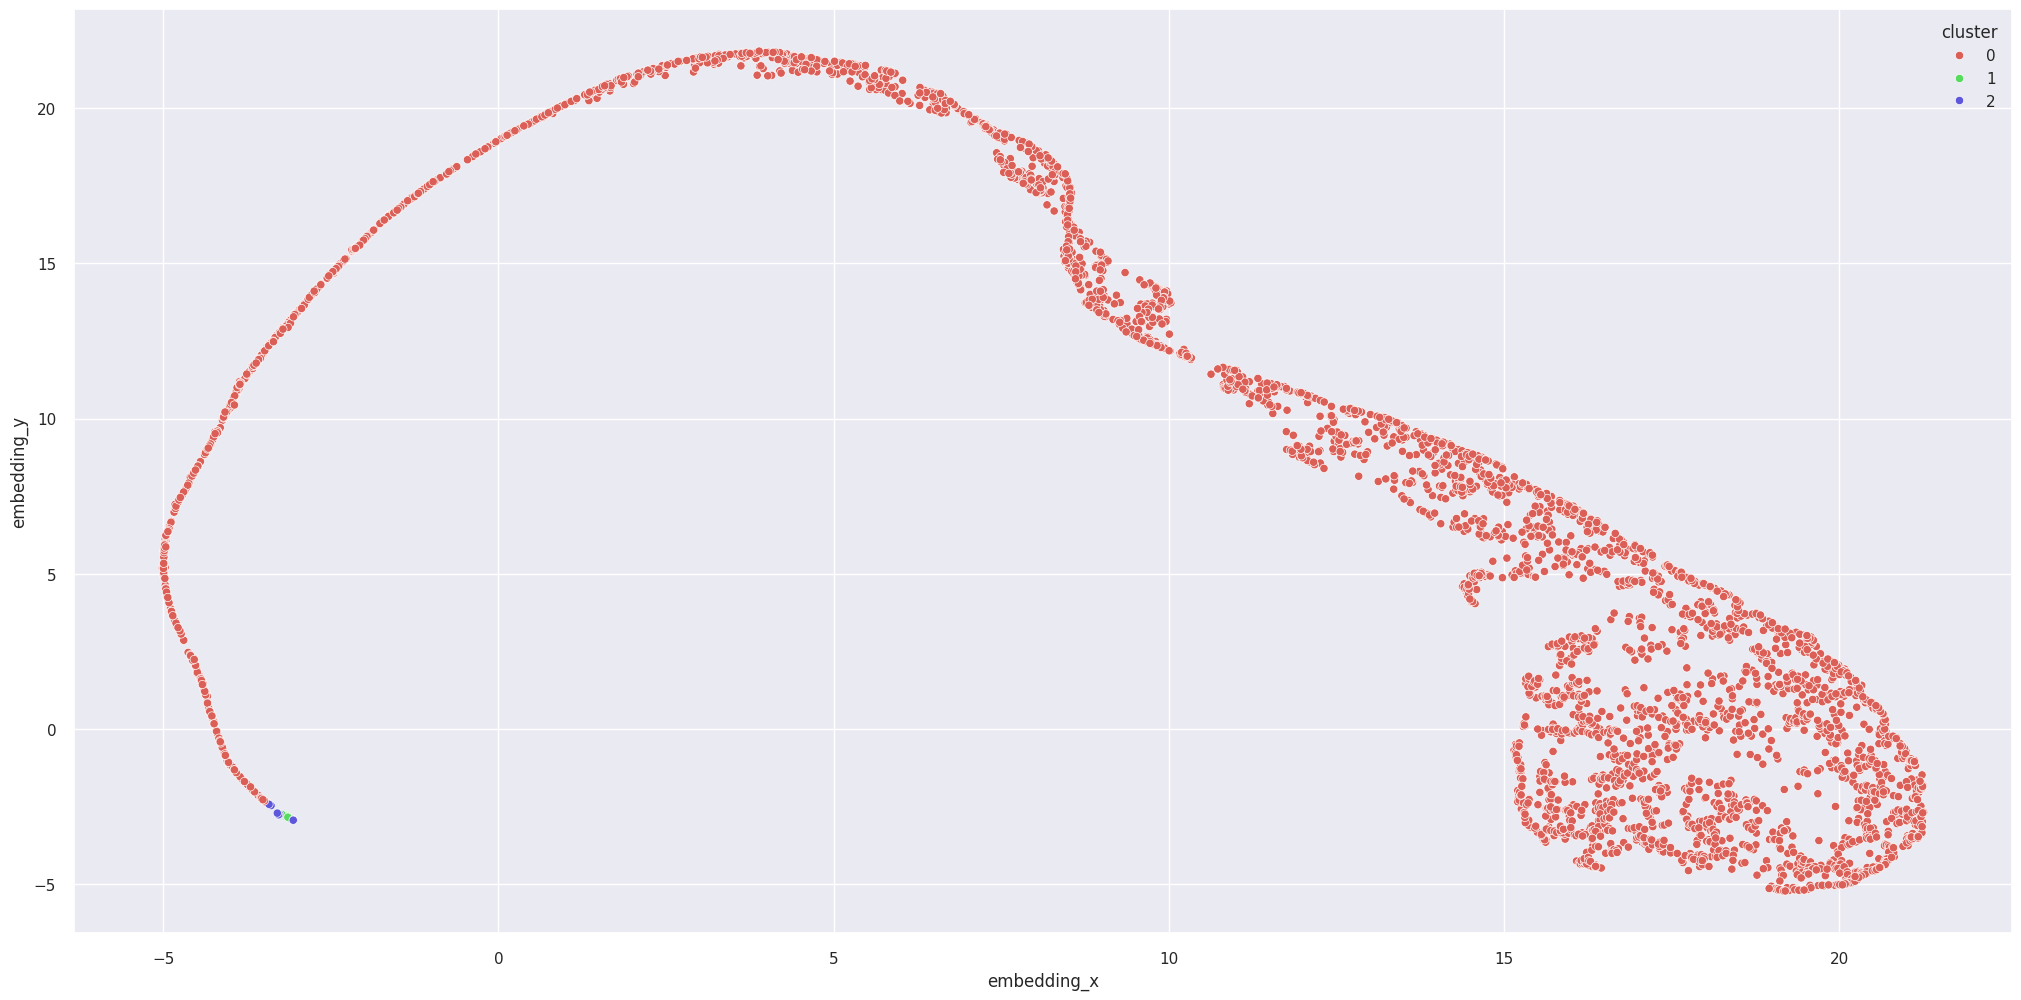

In [36]:
# pip install umap-learn

reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 10.4 Cluster Profile

In [37]:
# Number of customer
df_cluster = df10[['cluster', 'customer_id']].groupby( 'cluster').count().reset_index().rename( columns = { 'customer_id' : 'count' } )
df_cluster['perc_customer'] = df_cluster['count'] / df_cluster['count'].sum() * 100

# Average Recency Days
df_avg_recency_days = df10[['cluster', 'recency_days']].groupby( 'cluster').mean().reset_index()

# Average Purchase Frequeccy
df_avg_purchase_frequency = df10[['cluster', 'purchase_frequency']].groupby( 'cluster').mean().reset_index()

# Average Gross Revenue
df_avg_gross_revenue = df10[['cluster', 'gross_revenue']].groupby( 'cluster').mean().reset_index()

# Average Ticket
df_avg_ticket = df10[['cluster', 'average_ticket']].groupby( 'cluster').mean().reset_index()

# Merging datasets
df_cluster = pd.merge( df_cluster, df_avg_recency_days,       how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_avg_purchase_frequency, how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue,      how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_avg_ticket,             how='inner', on='cluster' )
df_cluster.head()


,cluster,count,perc_customer,recency_days,purchase_frequency,gross_revenue,average_ticket
0,0,4335,99.153705,92.257901,4.614533,1372.577826,27.290354
1,1,6,0.137237,7.166667,89.000000,182181.981667,253.626345
2,2,31,0.709058,13.290323,53.290323,40543.517742,201.894247
